<a href="https://colab.research.google.com/github/dikshank/Fabric_Defect_Detection/blob/main/Internship_Assignment_Fabric_Defect_detection(cosin_sim).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# moving the data to working directory for write permissions
import shutil
from pathlib import Path

src_folder = Path("/content/drive/MyDrive/CV_assignment_data/analmoly_detection_dataset")   # read-only root
dst_folder = Path("/content/Anomaly_dataset")     # writable destination

# If destination exists, delete it first to avoid copytree errors
if dst_folder.exists():
  shutil.rmtree(dst_folder)

# Copy entire directory tree (all subfolders + files)
shutil.copytree(src_folder, dst_folder)

print(f"Copied dataset from {src_folder} → {dst_folder}")


Copied dataset from /content/drive/MyDrive/CV_assignment_data/analmoly_detection_dataset → /content/Anomaly_dataset


In [36]:
import os

def count_files_in_subfolders(root_folder):
  total_files = 0
  results = {}

  for subdir, dirs, files in os.walk(root_folder):
    # Skip the root folder itself
    if subdir == root_folder:
      continue

    file_count = len([f for f in files if not f.startswith('.')])  # ignore hidden files
    results[subdir] = file_count
    total_files += file_count

  return results, total_files


# Example usage
root = "/content/Anomaly_dataset"
counts, total = count_files_in_subfolders(root)

for folder, count in counts.items():
  print(f"{folder}: {count} files")

print(f"\nTotal files across all subfolders: {total}")

/content/Anomaly_dataset/defect: 0 files
/content/Anomaly_dataset/defect/hole: 2 files
/content/Anomaly_dataset/defect/lycra_cut: 2 files
/content/Anomaly_dataset/defect/needln: 5 files
/content/Anomaly_dataset/defect/twoply: 3 files
/content/Anomaly_dataset/non_defect: 50 files

Total files across all subfolders: 62


Now I will add some good images to the defect dataset in a seperate sub folder to see if the model is able to tell the difference

In [37]:
import os
import random
import shutil
from pathlib import Path

# source and destination folders
src_folder = Path("/content/Anomaly_dataset/non_defect")
dst_folder = Path("/content/Anomaly_dataset/defect/good")

# make sure destination exists
dst_folder.mkdir(parents=True, exist_ok=True)

# get all image files (adjust extensions as needed)
image_files = [f for f in src_folder.glob("*") if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

# take 10 (or fewer if not enough files)
selected = random.sample(image_files, min(15, len(image_files)))

# move them
for f in selected:
    shutil.move(str(f), dst_folder / f.name)

print(f"Moved {len(selected)} images to {dst_folder}")

Moved 15 images to /content/Anomaly_dataset/defect/good


We need some images in validation set so we can actually find a threshold

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Extractor (up to layer3)
class ResNetMultiFeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    resnet = models.resnet18(pretrained=True)
    self.layer1 = nn.Sequential(*list(resnet.children())[:5])  # conv1+bn+relu+maxpool+layer1
    self.layer2 = resnet.layer2
    self.layer3 = resnet.layer3
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

  def forward(self, x):
    with torch.no_grad():
      x = self.layer1(x)
      x = self.layer2(x)
      f3 = self.layer3(x)  # [B, 256, H/16, W/16]
      f3_avg = self.avgpool(f3).view(x.size(0), -1)  # [B, 256]
      return f3_avg

# 2. Autoencoder
class FeatureAutoencoder(nn.Module):
  def __init__(self, input_dim=256, latent_dim=128):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, 128), nn.ReLU(),
      nn.Linear(128, latent_dim), nn.ReLU()
    )
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128), nn.ReLU(),
      nn.Linear(128, input_dim)
    )

  def forward(self, f):
    z = self.encoder(f)
    f_hat = self.decoder(z)
    return f_hat

# 3. Dataset for single folder
class SingleFolderDataset(Dataset):
  def __init__(self, folder, transform=None):
    self.files = glob.glob(folder + "/*.*")
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img = Image.open(self.files[idx]).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, 0  # dummy label

# 4. Training function
def train_feature_autoencoder(data_dir, epochs=20, batch_size=16):
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

  dataset = SingleFolderDataset(data_dir, transform=transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  feature_extractor = ResNetMultiFeatureExtractor().to(device).eval()
  model = FeatureAutoencoder(input_dim=256, latent_dim=128).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(epochs):
    running_loss = 0
    for imgs, _ in loader:
      imgs = imgs.to(device)
      f = feature_extractor(imgs)
      f_hat = model(f)
      cos_sim = F.cosine_similarity(f_hat, f, dim=1)  # [B]
      loss = 1 - cos_sim.mean()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss={running_loss/len(loader):.6f}")

  torch.save(model.state_dict(), "feature_autoencoder.pth")
  return model, feature_extractor

# 5. Compute anomaly scores for folder
def compute_scores_for_folder(model, feature_extractor, folder):
  device = next(model.parameters()).device
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
  ])
  scores = []
  for f in glob.glob(os.path.join(folder, "*.*")):
    try:
      img = Image.open(f).convert("RGB")
    except:
      continue
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
      ftr = feature_extractor(img_t)
      f_hat = model(ftr)
      cos_sim = F.cosine_similarity(ftr, f_hat, dim=1)  # [1] since batch=1
      score = 1 - cos_sim.item()
      scores.append(score)
  return scores

In [39]:
# train
model, feat_ext = train_feature_autoencoder("/content/Anomaly_dataset/non_defect", epochs=10, batch_size=16)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss=0.881935
Epoch 2/10, Loss=0.710905
Epoch 3/10, Loss=0.500546
Epoch 4/10, Loss=0.319597
Epoch 5/10, Loss=0.203066
Epoch 6/10, Loss=0.127440
Epoch 7/10, Loss=0.081647
Epoch 8/10, Loss=0.054628
Epoch 9/10, Loss=0.039840
Epoch 10/10, Loss=0.033312


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

train_seen: 35 images, mean score = 0.024649
good_test: 15 images, mean score = 0.025833
anomaly_type1: 2 images, mean score = 0.102758
anomaly_type2: 2 images, mean score = 0.114885
anomaly_type3: 5 images, mean score = 0.100647
anomaly_type4: 3 images, mean score = 0.129250


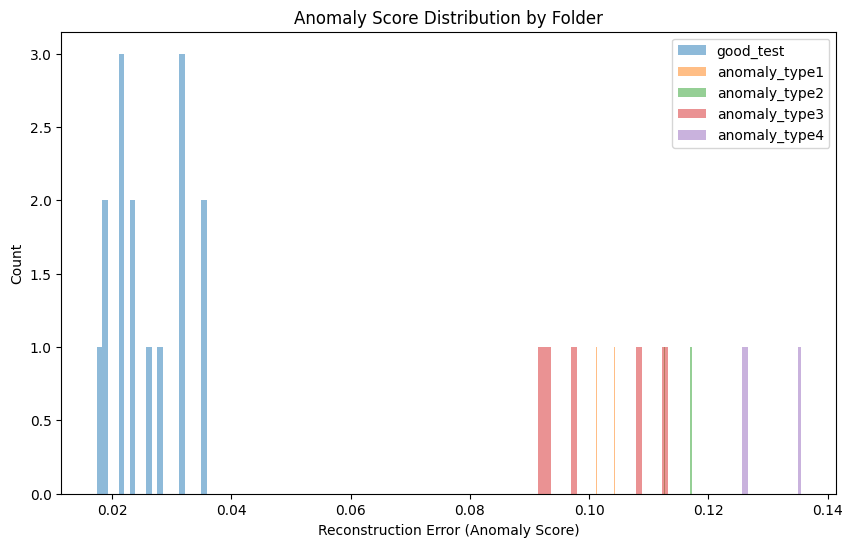

In [50]:
# Compute anomaly scores for multiple folders
folders = {
  "train_seen": "/content/Anomaly_dataset/non_defect",  # training set just for comparison
  "good_test": "/content/Anomaly_dataset/defect/good",  # unseen good data
  "anomaly_type1": "/content/Anomaly_dataset/defect/hole",
  "anomaly_type2": "/content/Anomaly_dataset/defect/lycra_cut",
  "anomaly_type3": "/content/Anomaly_dataset/defect/needln",
  "anomaly_type4": "/content/Anomaly_dataset/defect/twoply"
}

results = {}
for name, path in folders.items():
  if not os.path.exists(path):
    print(f"Folder not found: {path}")
    continue
  scores = compute_scores_for_folder(model, feat_ext, path)
  results[name] = scores
  print(f"{name}: {len(scores)} images, mean score = {np.mean(scores):.6f}")


plt.figure(figsize=(10,6))
for name, scores in results.items():
  if name == "train_seen":
    continue
  else:
    plt.hist(scores, bins=20, alpha=0.5, label=name)

plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Count")
plt.title("Anomaly Score Distribution by Folder")
plt.legend()
plt.show()


Great, we can see model has learned the distribution really well.

Chosen threshold = 0.070000
✅ Accuracy: 1.0000
Confusion Matrix:
 [[15  0]
 [ 0 12]]
Classification Report:
               precision    recall  f1-score   support

        good       1.00      1.00      1.00        15
     anomaly       1.00      1.00      1.00        12

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



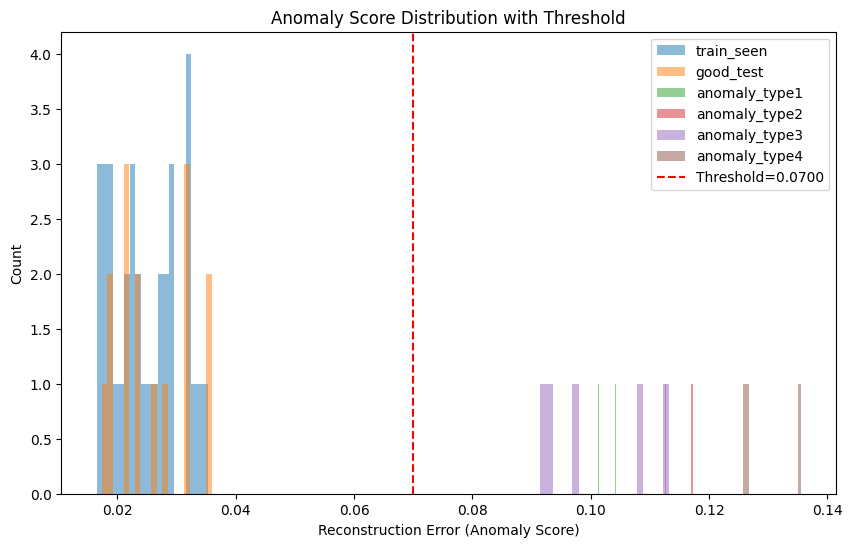

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Collect scores + labels
all_scores = []
all_labels = []  # 0 = good, 1 = anomaly

for name, path in folders.items():
  scores = results[name]
  if "train" in name:
    continue
  if "good" in name:
    labels = [0] * len(scores)
  else:
    labels = [1] * len(scores)
  all_scores.extend(scores)
  all_labels.extend(labels)

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

# It is not a good idea to check the threshold using the test data but here we don't have enough data for validation and we can see the distrubution clearly
# Ṣo this process is more of a formality
threshold = 0.07

print(f"Chosen threshold = {threshold:.6f}")

# Make predictions
preds = (all_scores >= threshold).astype(int)

# Evaluate
acc = accuracy_score(all_labels, preds)
cm = confusion_matrix(all_labels, preds)
report = classification_report(all_labels, preds, target_names=["good","anomaly"])

print(f"✅ Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

# Plot threshold line
plt.figure(figsize=(10,6))
for name, scores in results.items():
  plt.hist(scores, bins=20, alpha=0.5, label=name)
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold={threshold:.4f}")
plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Count")
plt.title("Anomaly Score Distribution with Threshold")
plt.legend()
plt.show()

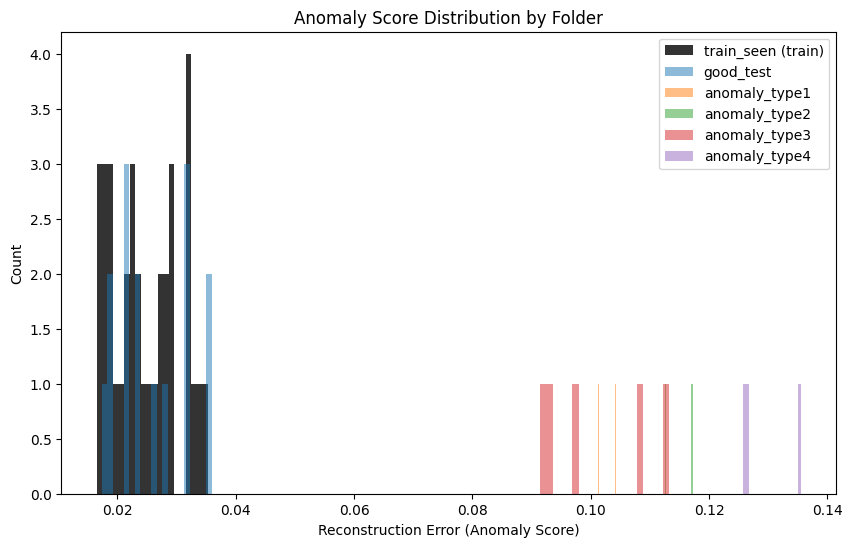

In [52]:
# we can also see how the training good data and test good data are learned by the model
plt.figure(figsize=(10,6))
for name, scores in results.items():
  if name == "train_seen":
    plt.hist(scores, bins=20, alpha=0.8, color="black", label=f"{name} (train)")   # This is just to see how the model treats trained good images
                                                                                   #  and unseen good images
  else:
    plt.hist(scores, bins=20, alpha=0.5, label=name)

plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Count")
plt.title("Anomaly Score Distribution by Folder")
plt.legend()
plt.show()


That's great, It means our model has learned the distribution of non-defect images perfectly